In [1]:
# Colab-ready deepfake training & evaluation script
# Split into cells using the `# %%` marker so you can paste the whole file into a Colab text editor
# and use `Runtime -> Run all` or paste each cell into separate notebook cells.

# %%
# Cell 1 — Environment, imports, and reproducibility
import os, sys, time, math, glob, shutil, random, hashlib, pickle
from pathlib import Path

# --- reproducibility ---
SEED = 42
random.seed(SEED)
import numpy as np
np.random.seed(SEED)

# Optional: install compatible packages in Colab if required
# Uncomment to run in fresh runtime environment
# !pip install -q numpy==1.25.2 opencv-python-headless==4.7.0.72 scikit-learn matplotlib imageio-ffmpeg tqdm

import cv2
import tensorflow as tf
from tensorflow.keras import layers, Input, Model, callbacks
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB4
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as irv2_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score,
    accuracy_score, precision_recall_fscore_support, balanced_accuracy_score
)
import matplotlib.pyplot as plt
import itertools

# Mixed precision (optional): enable if GPU supports it
try:
    if tf.config.list_physical_devices('GPU'):
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
        print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)


Mixed precision enabled.


In [2]:

# %%
# Cell 2 — Paths, Drive mount (Colab), and dataset extraction helpers

CACHE_DIR = "/content/deepfake_cache"
LOCAL_MODEL_PATH = "/content/deepfake_t4_local.h5"
FINAL_LOCAL = "/content/final.h5"
FINAL_WEIGHTS_LOCAL = "/content/final.weights.h5"
DATA_ROOT = "/content/deepfake_dataset"
DRIVE_MODEL_PATH = "/content/drive/MyDrive/deepfake_t4.h5"  # change if desired

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(DATA_ROOT, exist_ok=True)

# Mount Google Drive (uncomment to run in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_ROOT = '/content/drive/MyDrive'
    print('Drive mounted at /content/drive')
except Exception as e:
    DRIVE_ROOT = None
    print('Drive mount skipped or unavailable:', e)

# Helper to find and extract candidate zip archives that contain .mp4 files
import zipfile

def find_and_extract_candidates(names_list, target_subdir):
    target_dir = os.path.join(DATA_ROOT, target_subdir)
    os.makedirs(target_dir, exist_ok=True)
    search_roots = []
    if DRIVE_ROOT and os.path.exists(DRIVE_ROOT):
        search_roots.append(DRIVE_ROOT)
    search_roots.append(os.getcwd())
    found_any = False
    for root in search_roots:
        for path, dirs, files in os.walk(root):
            for fname in names_list:
                if fname in files:
                    zip_path = os.path.join(path, fname)
                    print(f"Found {fname} at {zip_path}. Extracting .mp4 files to {target_dir} ...")
                    try:
                        with zipfile.ZipFile(zip_path, 'r') as z:
                            for member in z.namelist():
                                if member.lower().endswith('.mp4'):
                                    member_name = os.path.basename(member)
                                    if not member_name:
                                        continue
                                    dest = os.path.join(target_dir, member_name)
                                    with z.open(member) as source, open(dest, "wb") as destf:
                                        shutil.copyfileobj(source, destf)
                        found_any = True
                    except zipfile.BadZipFile:
                        print(f"Error: {zip_path} is not a valid zip file.")
    if not found_any:
        print(f"Warning: none of {names_list} were found under {search_roots}.")
    return found_any

# Try common archive names
find_and_extract_candidates(["real.zip","r.zip"], "real/real")
find_and_extract_candidates(["fake.zip","f.zip"], "fake/fakes")

# Quick counts
real_count = len(glob.glob(os.path.join(DATA_ROOT, "real", "real", "*.mp4")))
fake_count = len(glob.glob(os.path.join(DATA_ROOT, "fake", "fakes", "*.mp4")))
print(f"Videos after extraction: real={real_count}, fake={fake_count}")
if real_count + fake_count == 0:
    print("No .mp4 files found in DATA_ROOT. Please upload real.zip/fake.zip to Drive or /content and re-run the extraction cell.")


Mounted at /content/drive
Drive mounted at /content/drive
Found real.zip at /content/drive/MyDrive/real.zip. Extracting .mp4 files to /content/deepfake_dataset/real/real ...
Found real.zip at /content/drive/MyDrive/real.zip. Extracting .mp4 files to /content/deepfake_dataset/real/real ...
Found fake.zip at /content/drive/MyDrive/fake.zip. Extracting .mp4 files to /content/deepfake_dataset/fake/fakes ...
Found fake.zip at /content/drive/MyDrive/fake.zip. Extracting .mp4 files to /content/deepfake_dataset/fake/fakes ...
Videos after extraction: real=363, fake=1002


In [3]:

# %%
# Cell 3 — PatentAlignedDeepfakeDetector class (model architecture + helpers)

class PatentAlignedDeepfakeDetector:
    def __init__(self, max_frames=6, resize_to=(224,224), ascii_grid=(80,40),
                 ascii_stats_dim=32, cache_dir=CACHE_DIR):
        self.max_frames = max_frames
        self.resize_to = resize_to
        self.ascii_grid = ascii_grid
        self.ascii_stats_dim = ascii_stats_dim
        self.ASCII_CHARS = "@%#*+=-:. "
        self.intensity_bins = np.linspace(0, 255, len(self.ASCII_CHARS))
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def _cache_key(self, video_path):
        return os.path.join(self.cache_dir, hashlib.md5(video_path.encode()).hexdigest()+".pkl")

    def vectorized_ascii_conversion(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        H, W = gray.shape
        gh, gw = self.ascii_grid
        if gh <= 0 or gw <= 0:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)
        crop_h, crop_w = (H//gh)*gh, (W//gw)*gw
        gray = gray[:crop_h,:crop_w] if crop_h>0 and crop_w>0 else gray
        if crop_h==0 or crop_w==0:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)
        cell_h, cell_w = crop_h//gh, crop_w//gw
        try:
            cells = gray.reshape(gh,cell_h,gw,cell_w)
            means = cells.mean(axis=(1,3))
            ascii_idx = np.digitize(means, self.intensity_bins)-1
            ascii_idx = np.clip(ascii_idx, 0, len(self.ASCII_CHARS)-1)
            ascii_vals = np.array([ord(self.ASCII_CHARS[i]) for i in ascii_idx.flatten()]).reshape(ascii_idx.shape)
            ascii_img = np.stack([ascii_vals]*3,axis=-1).astype(np.float32)
            return cv2.resize(ascii_img, self.resize_to)
        except Exception:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)

    def compute_ascii_stats(self, ascii_frames):
        ent = []
        for f in ascii_frames:
            flat = f[:,:,0].flatten()
            if len(flat)<3:
                ent.append((0.0,0.0))
                continue
            ent.append((float(np.std(flat)), float(np.mean(flat))))
        if len(ent)==0:
            packed = np.array([0.0,0.0])
        else:
            packed = np.mean(ent,axis=0)
        reps = int(np.ceil(self.ascii_stats_dim/packed.size))
        return np.tile(packed,reps)[:self.ascii_stats_dim].astype(np.float32)

    def extract_frames_dual_path(self, video_path):
        cache_file = self._cache_key(video_path)
        if os.path.exists(cache_file):
            try:
                return pickle.load(open(cache_file,"rb"))
            except Exception:
                pass

        cap = cv2.VideoCapture(video_path)
        pixel, ascii_ = [], []
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        if total > self.max_frames:
            idxs = np.linspace(0, total-1, self.max_frames, dtype=int)
        elif total > 0:
            idxs = range(0, min(total, self.max_frames))
        else:
            idxs = []
        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, f = cap.read()
            if not ret:
                continue
            f = cv2.resize(f, self.resize_to)[:,:,::-1]
            pixel.append(f)
            ascii_.append(self.vectorized_ascii_conversion(f))
        cap.release()
        while len(pixel) < self.max_frames:
            if pixel:
                pixel.append(pixel[-1].copy())
                ascii_.append(ascii_[-1].copy())
            else:
                pixel.append(np.zeros((*self.resize_to,3), np.uint8))
                ascii_.append(np.zeros((*self.resize_to,3), np.uint8))
        pixel = np.stack(pixel).astype(np.float32)
        ascii_ = np.stack(ascii_).astype(np.float32)
        stats = self.compute_ascii_stats(ascii_)
        data = (pixel, ascii_, stats)
        try:
            pickle.dump(data, open(cache_file, "wb"))
        except Exception:
            pass
        return data

    def build_patent_aligned_model(self):
        T, H, W = self.max_frames, *self.resize_to
        pix_in = Input((T,H,W,3), name="pixel_input")
        asc_in = Input((T,H,W,3), name="ascii_input")
        stats_in = Input((self.ascii_stats_dim,), name="ascii_stats_input")

        irv2 = InceptionResNetV2(include_top=False, weights="imagenet", pooling="avg", input_shape=(H,W,3))
        effb4 = EfficientNetB4(include_top=False, weights="imagenet", pooling="avg", input_shape=(H,W,3))
        irv2.trainable = False
        effb4.trainable = False

        pix = layers.TimeDistributed(layers.Lambda(lambda x: irv2(irv2_preprocess(x))))(pix_in)
        asc = layers.TimeDistributed(layers.Lambda(lambda x: effb4(eff_preprocess(x))))(asc_in)
        stats = layers.RepeatVector(T)(layers.Dense(32, activation="relu")(stats_in))
        fused = layers.Concatenate()([pix, asc, stats])

        temporal = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(fused)
        frame_logits = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"), name="frame_logits")(temporal)
        video_pred = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name="video_pred")(frame_logits)

        self.model = Model([pix_in, asc_in, stats_in], [video_pred, frame_logits])
        return self.model

    def _temporal_penalty_loss(self, y_true, frame_logits):
        diffs = frame_logits[:,1:,:] - frame_logits[:,:-1,:]
        return tf.reduce_mean(tf.abs(diffs))

    def compile_model(self, lr=1e-4, temporal_loss_weight=0.1):
        bce = tf.keras.losses.BinaryCrossentropy()
        def vloss(y_true, y_pred): return bce(y_true, y_pred)
        def tloss(y_true, y_pred): return self._temporal_penalty_loss(y_true, y_pred)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss={"video_pred": vloss, "frame_logits": tloss},
            loss_weights={"video_pred": 1.0, "frame_logits": temporal_loss_weight},
            metrics={"video_pred": [tf.keras.metrics.BinaryAccuracy(name="acc")]}
        )

    def dual_path_generator(self, paths, labels, batch_size=2, augment=False):
        while True:
            data = list(zip(paths, labels)); random.shuffle(data)
            for i in range(0, len(data), batch_size):
                batch = data[i:i+batch_size]
                Xp, Xa, Xs, Y = [], [], [], []
                for vp, lbl in batch:
                    pf, af, st = self.extract_frames_dual_path(vp)
                    if augment and random.random() > 0.5:
                        pf, af = pf[:, ::-1, :, :], af[:, ::-1, :, :]
                    Xp.append(pf.astype("float32"))
                    Xa.append(af.astype("float32"))
                    Xs.append(st.astype("float32"))
                    Y.append(lbl)
                Xp = np.stack(Xp)
                Xa = np.stack(Xa)
                Xs = np.stack(Xs)
                Yv = np.array(Y, dtype=np.float32).reshape(-1,1)
                Yf = np.zeros((len(Y), self.max_frames, 1), dtype=np.float32)
                yield [Xp, Xa, Xs], {"video_pred": Yv, "frame_logits": Yf}

    def predict_single(self, video_path):
        pixel_frames, ascii_frames, stats = self.extract_frames_dual_path(video_path)
        Xp = np.expand_dims(pixel_frames.astype("float32"), 0)
        Xa = np.expand_dims(ascii_frames.astype("float32"), 0)
        Xs = np.expand_dims(stats.astype("float32"), 0)
        preds = self.model.predict([Xp, Xa, Xs], verbose=0)
        video_pred, frame_preds = preds
        video_score = float(video_pred[0][0])
        frame_scores = frame_preds[0,:,0]
        return video_score, frame_scores


In [4]:

# %%
# Cell 4 — Dataset loader & warmup cache

def load_dataset(base_dir=DATA_ROOT, test_size=0.2):
    real_dir = os.path.join(base_dir, "real", "real")
    fake_dir = os.path.join(base_dir, "fake", "fakes")
    real = sorted(glob.glob(os.path.join(real_dir, "*.mp4")))
    fake = sorted(glob.glob(os.path.join(fake_dir, "*.mp4")))
    print(f"Found {len(real)} real videos, {len(fake)} fake videos")
    if len(real) + len(fake) == 0:
        raise FileNotFoundError("No mp4 files found.")
    paths = real + fake
    labels = [1]*len(real) + [0]*len(fake)
    strat = labels if len(set(labels))>1 else None
    return train_test_split(paths, labels, test_size=test_size, stratify=strat, random_state=SEED)


def warmup_cache(detector, paths, label="train"):
    print(f"[Warmup] Caching {len(paths)} {label} videos ...")
    for idx, vp in enumerate(paths):
        try:
            _ = detector.extract_frames_dual_path(vp)
        except Exception as e:
            print(f"[WARN] Failed caching {vp}: {e}")
        if (idx + 1) % 50 == 0:
            print(f"  Cached {idx+1}/{len(paths)} videos")
    print(f"[Warmup] Done caching {label}")


In [5]:

# %%
# Cell 5 — Training routine (tf.data wrapper, checkpointing, Drive copy)

def run_training(base_dir=DATA_ROOT, epochs=21, batch_size=2, resume=True,
                 local_ckpt=LOCAL_MODEL_PATH, drive_ckpt=DRIVE_MODEL_PATH):
    train_p, val_p, train_l, val_l = load_dataset(base_dir)
    det = PatentAlignedDeepfakeDetector(cache_dir=CACHE_DIR)
    _ = det.build_patent_aligned_model()
    det.compile_model()

    # warmup cache
    warmup_cache(det, train_p, label="train")
    warmup_cache(det, val_p, label="val")

    # resume weights if present (prefer drive then local)
    if resume:
        if drive_ckpt and os.path.exists(drive_ckpt):
            try:
                det.model.load_weights(drive_ckpt)
                print(f"[Resume] Loaded weights from drive checkpoint: {drive_ckpt}")
            except Exception as e:
                print("[Resume] Failed to load drive_ckpt:", e)
        elif os.path.exists(local_ckpt):
            try:
                det.model.load_weights(local_ckpt)
                print(f"[Resume] Loaded weights from local checkpoint: {local_ckpt}")
            except Exception as e:
                print("[Resume] Failed to load local_ckpt:", e)

    # tf.data wrappers
    T = det.max_frames
    H, W = det.resize_to
    ascii_dim = det.ascii_stats_dim

    inputs_signature = (
        tf.TensorSpec(shape=(None, T, H, W, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, T, H, W, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, ascii_dim), dtype=tf.float32)
    )
    outputs_signature = {
        "video_pred": tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        "frame_logits": tf.TensorSpec(shape=(None, T, 1), dtype=tf.float32)
    }
    full_signature = (inputs_signature, outputs_signature)

    def train_gen_adapter():
        gen = det.dual_path_generator(train_p, train_l, batch_size=batch_size, augment=True)
        for batch in gen:
            inputs_list, outputs = batch
            yield (inputs_list[0], inputs_list[1], inputs_list[2]), outputs

    def val_gen_adapter():
        gen = det.dual_path_generator(val_p, val_l, batch_size=batch_size, augment=False)
        for batch in gen:
            inputs_list, outputs = batch
            yield (inputs_list[0], inputs_list[1], inputs_list[2]), outputs

    train_ds = tf.data.Dataset.from_generator(train_gen_adapter, output_signature=full_signature).prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_generator(val_gen_adapter, output_signature=full_signature).prefetch(tf.data.AUTOTUNE)

    steps = max(1, len(train_p) // batch_size)
    val_steps = max(1, len(val_p) // batch_size)

    cb = [
        callbacks.ModelCheckpoint(local_ckpt, save_best_only=True, monitor="val_video_pred_acc", verbose=1, mode="max"),
        callbacks.EarlyStopping(monitor="val_video_pred_acc", patience=3, restore_best_weights=True, mode="max"),
        callbacks.ReduceLROnPlateau(monitor="val_video_pred_acc", factor=0.5, patience=2, verbose=1, mode="max")
    ]

    history = det.model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        callbacks=cb,
        verbose=1
    )

    # ensure best weights loaded
    if os.path.exists(local_ckpt):
        try:
            det.model.load_weights(local_ckpt)
            print(f"Loaded best weights from: {local_ckpt}")
        except Exception as e:
            print("Failed to load best weights after training:", e)

    # try to copy checkpoint to Drive location if available
    if drive_ckpt:
        try:
            shutil.copy(local_ckpt, drive_ckpt)
            print(f"Copied local checkpoint to Drive at: {drive_ckpt}")
        except Exception as e:
            print("Warning: failed to copy checkpoint to Drive:", e)

    # Save full model + weights locally (and to Drive folder if available)
    try:
        det.model.save(FINAL_LOCAL)
        print(f"Saved full model locally at: {FINAL_LOCAL}")
        if drive_ckpt and os.path.exists(os.path.dirname(drive_ckpt)):
            det.model.save(os.path.join(os.path.dirname(drive_ckpt), os.path.basename(FINAL_LOCAL)))
    except Exception as e:
        print("Warning: failed to save full model:", e)

    try:
        det.model.save_weights(FINAL_WEIGHTS_LOCAL)
        print(f"Saved weights locally at: {FINAL_WEIGHTS_LOCAL}")
        if drive_ckpt and os.path.exists(os.path.dirname(drive_ckpt)):
            shutil.copy(FINAL_WEIGHTS_LOCAL, os.path.join(os.path.dirname(drive_ckpt), os.path.basename(FINAL_WEIGHTS_LOCAL)))
    except Exception as e:
        print("Warning: failed to save weights:", e)

    return det, history, (train_p, val_p, train_l, val_l)


In [6]:

# %%
# Cell 6 — Training invocation (configure and run)

# Configure — edit these values as you like
EPOCHS = 11
BATCH_SIZE = 2
RESUME = True

# Adjust DRIVE_MODEL_PATH if you mounted Drive elsewhere
DRIVE_MODEL_PATH = DRIVE_MODEL_PATH if DRIVE_ROOT is not None else None

# Run training (this cell will start the training loop)
if (len(glob.glob(os.path.join(DATA_ROOT, "real", "real", "*.mp4"))) + len(glob.glob(os.path.join(DATA_ROOT, "fake", "fakes", "*.mp4")))) == 0:
    print("No data found in DATA_ROOT. Upload videos first, then run this cell.")
else:
    detector, history, (train_p, val_p, train_l, val_l) = run_training(
        base_dir=DATA_ROOT,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        resume=RESUME,
        local_ckpt=LOCAL_MODEL_PATH,
        drive_ckpt=DRIVE_MODEL_PATH
    )


Found 363 real videos, 1002 fake videos
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[Warmup] Caching 1092 train videos ...
  Cached 50/1092 videos
  Cached 100/1092 videos
  Cached 150/1092 videos
  Cached 200/1092 videos
  Cached 250/1092 videos
  Cached 300/1092 videos
  Cached 350/1092 videos
  Cached 400/1092 videos
  Cached 450/1092 videos
  Cached 500/1092 videos
  Cached 550/1092 videos
  Cached 600/1092 videos
  Cached 650/1092 videos
  Cached 700/1092 videos
  Cached 750/1092 videos
  Cached 800/1092 videos
  Cached 850/1092 videos
  Cached 900/1092 videos
  Cached 950/1092 videos
  Cached 1000/1092 videos
  Cached 1050/1092 videos
[Warmup] Done caching train
[Warmup] Caching 273 val videos ...
  Cached 50/273 videos
  Cached 100/273 videos
  Cached 150/273 videos
  Cached 200/273 videos
  Cached 250/273 videos
[Warmup] Done caching val
Epoch 1/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - frame_logits_loss: 0.0224 

546/546 ━━━━━━━━━━━━━━━━━━━━ 532s 530ms/step - frame_logits_loss: 0.0224 - loss: 0.6869 - video_pred_acc: 0.6888 - video_pred_loss: 0.6847 - val_frame_logits_loss: 0.0367 - val_loss: 0.5416 - val_video_pred_acc: 0.7316 - val_video_pred_loss: 0.5379 - learning_rate: 1.0000e-04
Epoch 2/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - frame_logits_loss: 0.0429 - loss: 0.5055 - video_pred_acc: 0.7759 - video_pred_loss: 0.5012
Epoch 2: val_video_pred_acc improved from 0.73162 to 0.82353, saving model to /content/deepfake_t4_local.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 211s 387ms/step - frame_logits_loss: 0.0429 - loss: 0.5055 - video_pred_acc: 0.7759 - video_pred_loss: 0.5012 - val_frame_logits_loss: 0.0588 - val_loss: 0.4794 - val_video_pred_acc: 0.8235 - val_video_pred_loss: 0.4735 - learning_rate: 1.0000e-04
Epoch 3/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - frame_logits_loss: 0.0554 - loss: 0.4840 - video_pred_acc: 0.8172 - video_pred_loss: 0.4785
Epoch 3: val_video_pred_acc improved from 0.82353 to 0.86765, saving model to /content/deepfake_t4_local.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 263s 481ms/step - frame_logits_loss: 0.0554 - loss: 0.4840 - video_pred_acc: 0.8172 - video_pred_loss: 0.4785 - val_frame_logits_loss: 0.0612 - val_loss: 0.4328 - val_video_pred_acc: 0.8676 - val_video_pred_loss: 0.4267 - learning_rate: 1.0000e-04
Epoch 4/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - frame_logits_loss: 0.0555 - loss: 0.4356 - video_pred_acc: 0.8256 - video_pred_loss: 0.4301
Epoch 4: val_video_pred_acc did not improve from 0.86765
546/546 ━━━━━━━━━━━━━━━━━━━━ 261s 479ms/step - frame_logits_loss: 0.0555 - loss: 0.4356 - video_pred_acc: 0.8256 - video_pred_loss: 0.4300 - val_frame_logits_loss: 0.0712 - val_loss: 0.5990 - val_video_pred_acc: 0.6618 - val_video_pred_loss: 0.5919 - learning_rate: 1.0000e-04
Epoch 5/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - frame_logits_loss: 0.0539 - loss: 0.4008 - video_pred_acc: 0.8437 - video_pred_loss: 0.3954
Epoch 5: val_video_pred_acc did not improve from 0.86765

Epoch 5: ReduceLROnPlateau reducing

546/546 ━━━━━━━━━━━━━━━━━━━━ 263s 482ms/step - frame_logits_loss: 0.0541 - loss: 0.3631 - video_pred_acc: 0.8820 - video_pred_loss: 0.3577 - val_frame_logits_loss: 0.0458 - val_loss: 0.3612 - val_video_pred_acc: 0.8860 - val_video_pred_loss: 0.3566 - learning_rate: 5.0000e-05
Epoch 7/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - frame_logits_loss: 0.0491 - loss: 0.3022 - video_pred_acc: 0.9009 - video_pred_loss: 0.2972
Epoch 7: val_video_pred_acc improved from 0.88603 to 0.89338, saving model to /content/deepfake_t4_local.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 216s 396ms/step - frame_logits_loss: 0.0491 - loss: 0.3022 - video_pred_acc: 0.9009 - video_pred_loss: 0.2973 - val_frame_logits_loss: 0.0401 - val_loss: 0.3493 - val_video_pred_acc: 0.8934 - val_video_pred_loss: 0.3453 - learning_rate: 5.0000e-05
Epoch 8/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - frame_logits_loss: 0.0421 - loss: 0.2821 - video_pred_acc: 0.9202 - video_pred_loss: 0.2779
Epoch 8: val_video_pred_acc improved from 0.89338 to 0.90074, saving model to /content/deepfake_t4_local.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 220s 403ms/step - frame_logits_loss: 0.0421 - loss: 0.2822 - video_pred_acc: 0.9201 - video_pred_loss: 0.2779 - val_frame_logits_loss: 0.0376 - val_loss: 0.3328 - val_video_pred_acc: 0.9007 - val_video_pred_loss: 0.3290 - learning_rate: 5.0000e-05
Epoch 9/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - frame_logits_loss: 0.0403 - loss: 0.2807 - video_pred_acc: 0.9066 - video_pred_loss: 0.2766
Epoch 9: val_video_pred_acc did not improve from 0.90074
546/546 ━━━━━━━━━━━━━━━━━━━━ 217s 398ms/step - frame_logits_loss: 0.0403 - loss: 0.2806 - video_pred_acc: 0.9066 - video_pred_loss: 0.2766 - val_frame_logits_loss: 0.0439 - val_loss: 0.3450 - val_video_pred_acc: 0.8897 - val_video_pred_loss: 0.3406 - learning_rate: 5.0000e-05
Epoch 10/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - frame_logits_loss: 0.0357 - loss: 0.2591 - video_pred_acc: 0.9256 - video_pred_loss: 0.2555
Epoch 10: val_video_pred_acc improved from 0.90074 to 0.90809, saving model to /content/deep

546/546 ━━━━━━━━━━━━━━━━━━━━ 214s 392ms/step - frame_logits_loss: 0.0357 - loss: 0.2591 - video_pred_acc: 0.9256 - video_pred_loss: 0.2555 - val_frame_logits_loss: 0.0360 - val_loss: 0.3127 - val_video_pred_acc: 0.9081 - val_video_pred_loss: 0.3091 - learning_rate: 5.0000e-05
Epoch 11/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - frame_logits_loss: 0.0341 - loss: 0.2408 - video_pred_acc: 0.9252 - video_pred_loss: 0.2374
Epoch 11: val_video_pred_acc improved from 0.90809 to 0.91544, saving model to /content/deepfake_t4_local.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 214s 393ms/step - frame_logits_loss: 0.0341 - loss: 0.2408 - video_pred_acc: 0.9252 - video_pred_loss: 0.2374 - val_frame_logits_loss: 0.0335 - val_loss: 0.3053 - val_video_pred_acc: 0.9154 - val_video_pred_loss: 0.3020 - learning_rate: 5.0000e-05


Loaded best weights from: /content/deepfake_t4_local.h5
Copied local checkpoint to Drive at: /content/drive/MyDrive/deepfake_t4.h5


Saved full model locally at: /content/final.h5
Saved weights locally at: /content/final.weights.h5


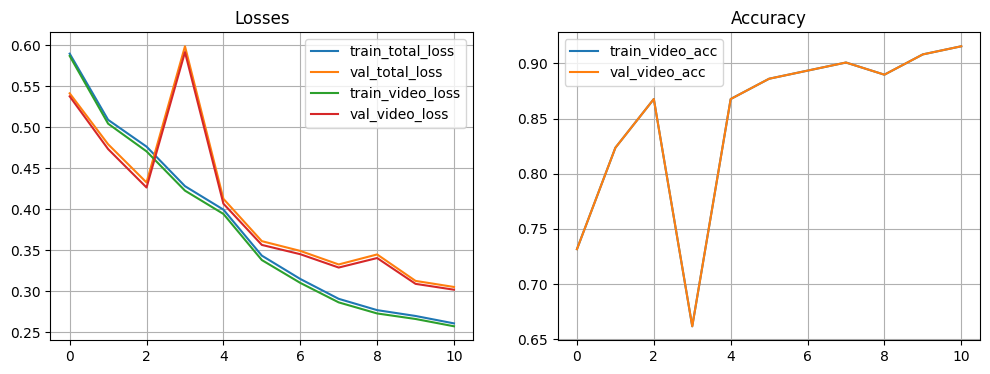

Saved history to /content/drive/MyDrive/deepfake_history.pkl


In [7]:

# %%
# Cell 7 — Plot training history and save history

def plot_history(history, save_path=None):
    hist = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    if "loss" in hist:
        plt.plot(hist["loss"], label="train_total_loss")
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label="val_total_loss")
    if "video_pred_loss" in hist:
        plt.plot(hist["video_pred_loss"], label="train_video_loss")
    if "val_video_pred_loss" in hist:
        plt.plot(hist["val_video_pred_loss"], label="val_video_loss")
    plt.title("Losses")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    acc_key = next((k for k in hist.keys() if k.endswith('video_pred_acc') or k == 'video_pred_acc' or k=='acc' or k=='accuracy'), None)
    val_acc_key = next((k for k in hist.keys() if k.startswith('val') and (k.endswith('video_pred_acc') or k=='val_accuracy' or k=='val_acc')), None)
    if acc_key and acc_key in hist:
        plt.plot(hist[acc_key], label="train_video_acc")
    if val_acc_key and val_acc_key in hist:
        plt.plot(hist[val_acc_key], label="val_video_acc")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Plot if history exists
try:
    plot_history(history)
except Exception as e:
    print('Could not plot history (is history defined?):', e)

# Optionally persist history to Drive
try:
    if 'history' in globals() and DRIVE_ROOT:
        import pickle
        hpath = os.path.join(DRIVE_ROOT, 'deepfake_history.pkl')
        with open(hpath, 'wb') as f:
            pickle.dump(history.history, f)
        print('Saved history to', hpath)
except Exception as e:
    print('Saving history to Drive failed:', e)


[Evaluation] Predicting validation videos (this may take time)...
=== Per-Video Metrics ===
Samples: 273  Accuracy: 0.9158  Balanced: 0.8468  AUC: 0.8558
Weighted Precision: 0.9219  Recall: 0.9158  F1: 0.9108
Classification report (video):               precision    recall  f1-score   support

           0     0.9005    0.9950    0.9454       200
           1     0.9808    0.6986    0.8160        73

    accuracy                         0.9158       273
   macro avg     0.9406    0.8468    0.8807       273
weighted avg     0.9219    0.9158    0.9108       273

=== Per-Frame Metrics (frames assumed labeled same as their video) ===
Frames: 1638  Accuracy: 0.9145  Balanced: 0.8453  AUC: 0.8610
Weighted Precision: 0.9205  Recall: 0.9145  F1: 0.9095
Classification report (frame):               precision    recall  f1-score   support

           0     0.8997    0.9942    0.9446      1200
           1     0.9776    0.6963    0.8133       438

    accuracy                         0.9145      1

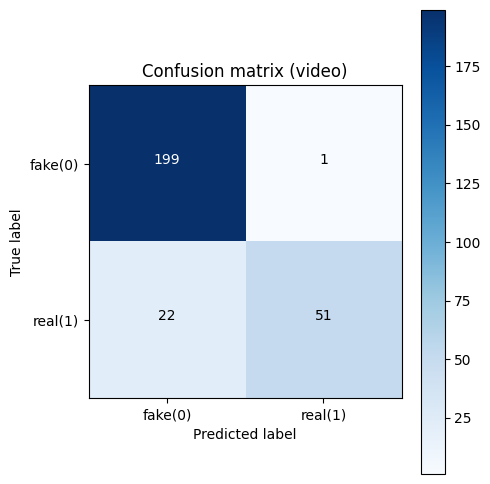

Saved ROC (video) to /content/drive/MyDrive/roc_video.png


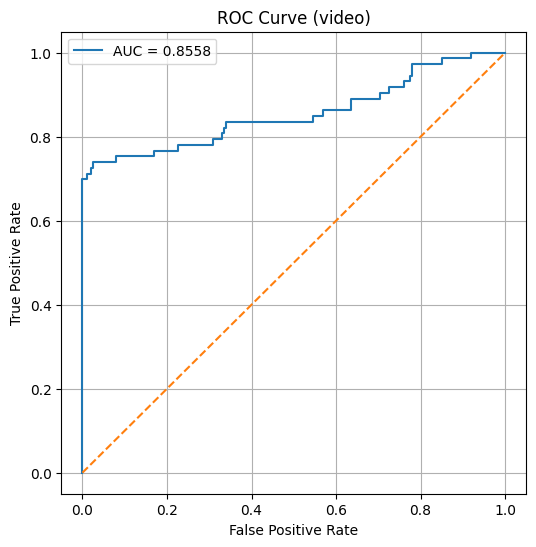

Saved ROC (frame) to /content/drive/MyDrive/roc_frame.png


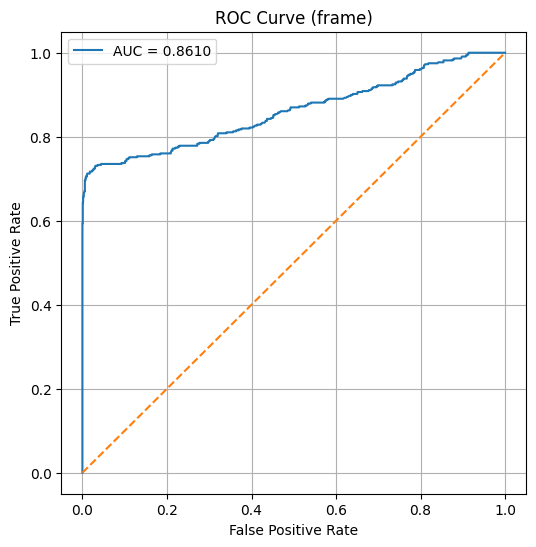

Artifacts (local):
 - local checkpoint: /content/deepfake_t4_local.h5
 - final model: /content/final.h5
 - final weights: /content/final.weights.h5
If Drive mounted, artifacts copied under your Drive folder near DRIVE_MODEL_PATH (if available).


In [8]:

# %%
# Cell 8 — Final evaluation: per-video, per-frame, confusion matrix, ROC

def evaluate_and_plot(detector, val_paths, val_labels, drive_folder=None):
    y_true_v, y_score_v, y_pred_v = [], [], []
    y_true_f_all = []
    y_score_f_all = []
    y_pred_f_all = []

    T = detector.max_frames

    print("[Evaluation] Predicting validation videos (this may take time)...")
    for vp, lbl in zip(val_paths, val_labels):
        try:
            vscore, fscores = detector.predict_single(vp)
        except Exception as e:
            print(f"[WARN] predict failed for {vp}: {e}")
            vscore = 0.5
            fscores = np.full((T,), 0.5)
        y_true_v.append(int(lbl))
        y_score_v.append(float(vscore))
        y_pred_v.append(int(vscore >= 0.5))

        y_true_f_all.extend([int(lbl)] * T)
        y_score_f_all.extend([float(s) for s in fscores[:T]])
        y_pred_f_all.extend([int(s >= 0.5) for s in fscores[:T]])

    y_true_v = np.array(y_true_v)
    y_score_v = np.array(y_score_v)
    y_pred_v = np.array(y_pred_v)

    y_true_f = np.array(y_true_f_all)
    y_score_f = np.array(y_score_f_all)
    y_pred_f = np.array(y_pred_f_all)

    # Per-video metrics
    acc_v = accuracy_score(y_true_v, y_pred_v)
    bal_acc_v = balanced_accuracy_score(y_true_v, y_pred_v)
    p_v, r_v, f1_v, _ = precision_recall_fscore_support(y_true_v, y_pred_v, average='weighted')
    try:
        auc_v = roc_auc_score(y_true_v, y_score_v)
    except Exception:
        auc_v = float('nan')

    print("=== Per-Video Metrics ===")
    print(f"Samples: {len(y_true_v)}  Accuracy: {acc_v:.4f}  Balanced: {bal_acc_v:.4f}  AUC: {auc_v:.4f}")
    print(f"Weighted Precision: {p_v:.4f}  Recall: {r_v:.4f}  F1: {f1_v:.4f}")
    print("Classification report (video):", classification_report(y_true_v, y_pred_v, digits=4))

    # Per-frame metrics
    acc_f = accuracy_score(y_true_f, y_pred_f)
    bal_acc_f = balanced_accuracy_score(y_true_f, y_pred_f)
    p_f, r_f, f1_f, _ = precision_recall_fscore_support(y_true_f, y_pred_f, average='weighted')
    try:
        auc_f = roc_auc_score(y_true_f, y_score_f)
    except Exception:
        auc_f = float('nan')

    print("=== Per-Frame Metrics (frames assumed labeled same as their video) ===")
    print(f"Frames: {len(y_true_f)}  Accuracy: {acc_f:.4f}  Balanced: {bal_acc_f:.4f}  AUC: {auc_f:.4f}")
    print(f"Weighted Precision: {p_f:.4f}  Recall: {r_f:.4f}  F1: {f1_f:.4f}")
    print("Classification report (frame):", classification_report(y_true_f, y_pred_f, digits=4))

    # Confusion matrix (video)
    cm_v = confusion_matrix(y_true_v, y_pred_v)
    plt.figure(figsize=(5,5))
    plt.imshow(cm_v, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix (video)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['fake(0)','real(1)'])
    plt.yticks(tick_marks, ['fake(0)','real(1)'])
    thresh = cm_v.max() / 2.
    for i, j in itertools.product(range(cm_v.shape[0]), range(cm_v.shape[1])):
        plt.text(j, i, format(cm_v[i, j], 'd'), horizontalalignment='center', color='white' if cm_v[i, j] > thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if drive_folder:
        p = os.path.join(drive_folder, 'confusion_matrix_video.png')
        plt.savefig(p, bbox_inches='tight')
        print('Saved confusion matrix (video) to', p)
    plt.show()

    # ROC (video)
    try:
        fpr, tpr, _ = roc_curve(y_true_v, y_score_v)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0,1],[0,1],'--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (video)')
        plt.legend()
        plt.grid(True)
        if drive_folder:
            p = os.path.join(drive_folder, 'roc_video.png')
            plt.savefig(p, bbox_inches='tight')
            print('Saved ROC (video) to', p)
        plt.show()
    except Exception as e:
        print('Could not compute ROC (video):', e)

    # ROC (frame)
    try:
        fpr, tpr, _ = roc_curve(y_true_f, y_score_f)
        roc_auc_f = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc_f:.4f}')
        plt.plot([0,1],[0,1],'--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (frame)')
        plt.legend()
        plt.grid(True)
        if drive_folder:
            p = os.path.join(drive_folder, 'roc_frame.png')
            plt.savefig(p, bbox_inches='tight')
            print('Saved ROC (frame) to', p)
        plt.show()
    except Exception as e:
        print('Could not compute ROC (frame):', e)

    return {
        'video': {'y_true': y_true_v, 'y_score': y_score_v, 'y_pred': y_pred_v},
        'frame': {'y_true': y_true_f, 'y_score': y_score_f, 'y_pred': y_pred_f}
    }

# Run evaluation if training produced variables
try:
    if 'detector' in globals() and 'val_p' in globals() and 'val_l' in globals():
        drive_folder = os.path.dirname(DRIVE_MODEL_PATH) if (DRIVE_ROOT and DRIVE_MODEL_PATH) else None
        eval_results = evaluate_and_plot(detector, val_p, val_l, drive_folder=drive_folder)
    else:
        print('Evaluation skipped: detector or validation sets not found in the notebook globals.')
except Exception as e:
    print('Evaluation failed:', e)

# %%
# End of notebook — summary of artifact locations
print('Artifacts (local):')
print(' - local checkpoint:', LOCAL_MODEL_PATH)
print(' - final model:', FINAL_LOCAL)
print(' - final weights:', FINAL_WEIGHTS_LOCAL)
if DRIVE_ROOT:
    print('If Drive mounted, artifacts copied under your Drive folder near DRIVE_MODEL_PATH (if available).')
